## **Mask Detection - Group 3**

In [ ]:
pip install mtcnn

     |████████████████████████████████| 2.3MB 5.1MB/s 


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow import keras
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json
from keras.callbacks import ModelCheckpoint
from mtcnn import MTCNN

In [ ]:
# parameter
img_rows, img_cols = 64, 64
color_type = 1
random_state = 45
epochs = 20
batch_size = 32

### **Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd ./drive/Shared\ drives/Machine\ Learning/Data

/content/drive/Shared drives/Machine Learning/Data


In [ ]:
ls

annotations/  images/  meta.json  submission.csv  test.jpeg  train.csv


In [ ]:
meta_data = pd.read_csv('train.csv')

In [ ]:
meta_data.classname.unique()

array(['face_with_mask', 'mask_colorful', 'face_no_mask',
       'face_with_mask_incorrect', 'mask_surgical', 'face_other_covering',
       'scarf_bandana', 'eyeglasses', 'helmet', 'face_shield',
       'sunglasses', 'hood', 'hat', 'goggles', 'hair_net', 'hijab_niqab',
       'other', 'gas_mask', 'balaclava_ski_mask', 'turban'], dtype=object)

In [ ]:
df = meta_data[(meta_data.classname=='face_with_mask') | (meta_data.classname=='face_no_mask')].sort_values('name').reset_index(drop=True)

In [ ]:
len(df.name.unique())

3390

In [ ]:
df.head()

,name,x1,x2,y1,y2,classname
0,1801.jpg,451,186,895,697,face_no_mask
1,1802.jpg,110,71,273,272,face_with_mask
2,1803.jpg,126,75,303,333,face_with_mask
3,1804.jpg,112,113,262,307,face_with_mask
4,1805.jpg,728,180,853,336,face_with_mask


In [ ]:
df.groupby('classname').count()

,name,x1,x2,y1,y2
classname,,,,,
face_no_mask,1569,1569,1569,1569,1569
face_with_mask,4180,4180,4180,4180,4180


In [ ]:
df.shape

(5749, 6)

In [ ]:
def plot_image(df, row, col):
    fig,axs = plt.subplots(row, col, figsize=(12, 12))
    fig.tight_layout()
    fig.subplots_adjust(hspace=-0.5)
  
    for i,ax in enumerate(axs.flatten()):
      row = df.iloc[i]
      img = plt.imread(os.path.join("images", row['name']))
      ax.imshow(img)
      face = patches.Rectangle((row.x1,row.x2),row.y1-row.x1,row.y2-row.x2,linewidth=2,edgecolor='r',facecolor='none')

      ax.add_patch(face)
      # ax.axis('off')

    
  plt.suptitle('Original Images', size=30)
  plt.show()

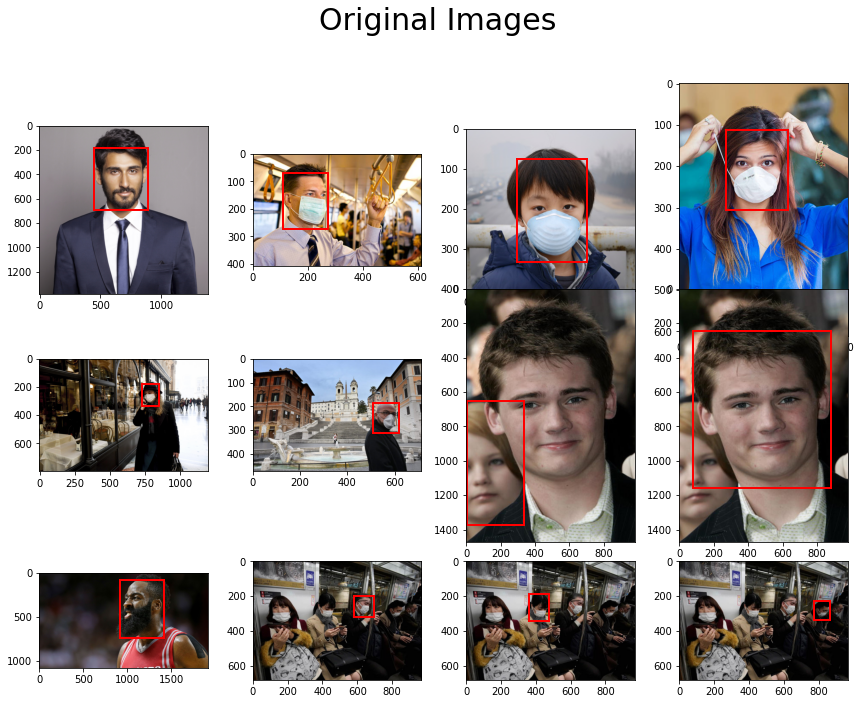

In [ ]:
plot_image(df, 3, 4)

### **Data Processing & Clean**

In [ ]:
def img_to_cv2(path, x1, x2, y1, y2, img_rows, img_cols, color_type=1):
    img_arr = []
    # Load as grayscale
    if color_type == 1:
        img_arr = cv2.imread(path, 0)
    elif color_type == 3:
        img_arr = cv2.imread(path)
      
    # extract face image
    img_arr = img_arr[x2:y2, x1:y1]
    # Reshape size
    resized = cv2.resize(img_arr, (img_cols, img_rows))

    return resized

In [ ]:
def load_data(df, img_rows, img_cols, color_type=1):
    img = []
    label = []
    for _,row in df.iterrows():
        path = os.path.join("images", row['name'])
        resized = img_to_cv2(path, row['x1'], row['x2'], row['y1'], row['y2'], img_rows, img_cols, color_type)
        img.append(resized)
        label.append(row.classname) 
    
    # 1: face with mask
    # 0: face without mask
    labelencoder = LabelEncoder()
    label = labelencoder.fit_transform(label)

    return img, label

In [ ]:
X, y = load_data(df, img_rows, img_cols, color_type)

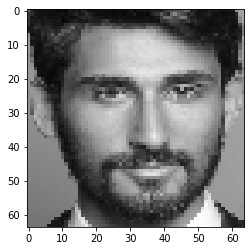

In [ ]:
test1 = cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB)
plt.imshow(test1)

In [ ]:
a, b = load_data(df.iloc[[0]],img_rows, img_cols, 3)

In [ ]:
X[0]

array([[100,  41,  20, ..., 139, 160, 160],
       [ 59,  44,  25, ...,  40, 160, 159],
       [ 63,  19,  28, ...,  29, 140, 168],
       ...,
       [118, 117, 118, ...,  35, 144, 150],
       [117, 117, 118, ...,  29,  45,  39],
       [116, 116, 115, ...,  28,  33,  48]], dtype=uint8)

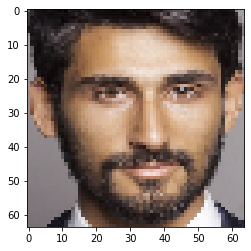

In [ ]:
test2 = cv2.cvtColor(a[0], cv2.COLOR_BGR2RGB)
plt.imshow(test2)

In [ ]:
def normalize_data(X, y, img_rows, img_cols, color_type=1):
    X = np.array(X).reshape(-1, img_rows, img_cols, color_type)
    y = np.array(y)
    y = tf.keras.utils.to_categorical(y)
    X = X.astype('float32') / 255

    return X, y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)
X_train, y_train = normalize_data(X_train, y_train, img_rows, img_cols, color_type)
X_test, y_test = normalize_data(X_test, y_test, img_rows, img_cols, color_type)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (4599, 64, 64, 1)
y_train: (4599, 2)
X_test: (1150, 64, 64, 1)
y_test: (1150, 2)


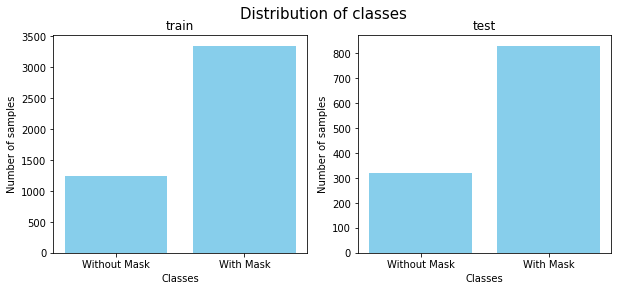

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].bar(['Without Mask', 'With Mask'],sum(y_train),color='skyblue')
ax[0].set_title('train')
ax[0].set_xlabel('Classes')
ax[0].set_ylabel('Number of samples')

ax[1].bar(['Without Mask', 'With Mask'],sum(y_test),color='skyblue')
ax[1].set_title('test')
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Number of samples')

plt.suptitle('Distribution of classes', size=15)
plt.show()

### **Build Model**

In [ ]:
def create_cnn_model(img_rows, img_cols, color_type=1):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))

    model.summary()
    
    return model

In [ ]:
def train_model(model, X_train, y_train, epochs, batch_size, checkpoint=None):
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,shuffle=True, callbacks=[checkpoint])
    return history

In [ ]:
checkpoint_path = '/checkpoint'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [ ]:
model = create_cnn_model(img_rows, img_cols, color_type)
history = train_model(model, X_train, y_train, epochs, batch_size, checkpoint)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       7

In [ ]:
model.load_weights(checkpoint_path)

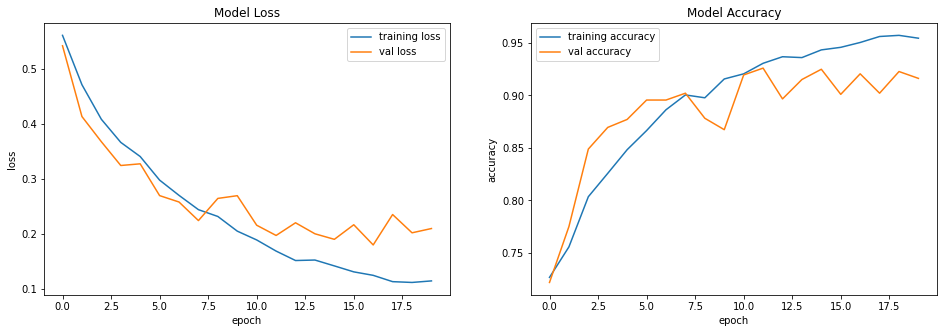

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].plot(history.history['loss'],label='training loss')
ax[0].plot(history.history['val_loss'],label='val loss')
ax[0].set_title('Model Loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend()

ax[1].plot(history.history['accuracy'],label='training accuracy')
ax[1].plot(history.history['val_accuracy'],label='val accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend()

In [ ]:
train_score = model.evaluate(X_train, y_train, batch_size=batch_size)
test_score = model.evaluate(X_test, y_test, batch_size=batch_size)

36/36 [==============================] - 2s 59ms/step - loss: 0.1941 - accuracy: 0.9252


In [ ]:
# def create_vgg16_model():
#   model = tf.keras.applications.VGG16() 
#   model.summary()
    
#   return model

In [ ]:
# vgg16_model = create_vgg16_model(img_rows, img_cols, color_type)
# history = train_model(vgg16_model, X_train, y_train, X_val, y_val, 10, 32)

### **Predict Image**

In [ ]:
def face_detect(path):
    box_arr = []
    img = plt.imread(path)
    faces = MTCNN().detect_faces(img)
    for face in faces:
        box_arr.append(face['box'])
    return box_arr

In [ ]:
def load_test_data(path, img_rows, img_cols, color_type=1):
    img = []
    box_arr = face_detect(path)
    if (len(box_arr) == 0):
        print("No face has been detected")
        return
    for box in box_arr:
        x, y, width, height = box[0], box[1], box[2], box[3]
        x1 = x
        x2 = y
        y1 = x + width
        y2 = y + height
        resized = img_to_cv2(path, x1, x2, y1, y2, img_rows, img_cols, color_type)
        img.append(resized)

    return img

In [ ]:
def normalize_test_data(X_test, img_rows, img_cols, color_type=1):
    X_test = np.array(X_test)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, color_type)
    X_test = X_test.astype('float32') / 255,
    
    return X_test

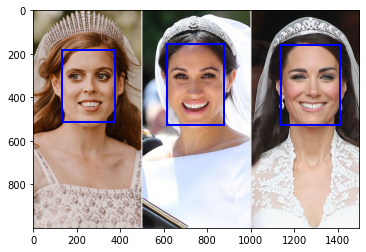

In [ ]:
file_name = "test.jpeg"
path = file_name

fig,ax = plt.subplots()
img = plt.imread(path)
ax.imshow(img)

# x1, y1, width, height = face['box']
faces = face_detect(path)
for i,face in enumerate(faces):
    x1, y1, width, height = face[0], face[1], face[2], face[3]
    face = patches.Rectangle((x1,y1),width,height,linewidth=2,edgecolor='b',facecolor='none')
    ax.add_patch(face)
  
plt.show()

In [ ]:
data_1 = load_test_data(path, img_rows, img_cols, color_type)
data_1 = normalize_test_data(data_1, img_rows, img_cols, color_type)

In [ ]:
model.predict(data_1)

array([[9.8476613e-01, 1.5233894e-02],
       [9.9991572e-01, 8.4258529e-05],
       [9.9990559e-01, 9.4352967e-05]], dtype=float32)

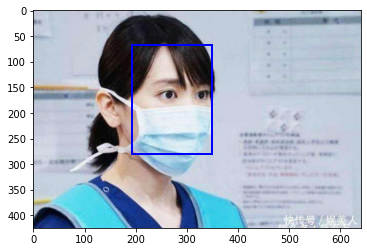

In [ ]:
file_name = "test2.jpeg"
path = file_name

fig,ax = plt.subplots()
img = plt.imread(path)
ax.imshow(img)

# x1, y1, width, height = face['box']
faces = face_detect(path)
for i,face in enumerate(faces):
    x1, y1, width, height = face[0], face[1], face[2], face[3]
    face = patches.Rectangle((x1,y1),width,height,linewidth=2,edgecolor='b',facecolor='none')
    ax.add_patch(face)
  
plt.show()

In [ ]:
data_2 = load_test_data(path, img_rows, img_cols, color_type)
data_2 = normalize_test_data(data_2, img_rows, img_cols, color_type)

In [ ]:
model.predict(data_2)

array([[0.01019729, 0.9898028 ]], dtype=float32)

In [ ]:
model.save('cnn_model')